adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from colorclade import draw_colorclade_tree
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm

from pylib._build_hstrat_surfaces import build_hstrat_surfaces
from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._hstrat_reconstruct_dataframe import (
    hstrat_reconstruct_dataframe,
)
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_hstrat_surface_dataframe import (
    make_hstrat_surface_dataframe,
)
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._transform_box_max import TransformBoxMax
from pylib.difflenia._AttributeBoxMax import AttributeBoxMax
from pylib.difflenia._VideoWriter import VideoWriter
from pylib.difflenia._generate_observations import generate_observations

torch.set_default_tensor_type("torch.FloatTensor")
make_reproducible()


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-25T01:34:21.369554+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

torch     : 2.0.1
matplotlib: 3.9.2

Watermark: 2.4.3



In [4]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O '/tmp/crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O '/tmp/crea2.pickle'
!wget  'https://osf.io/ba536/download' -O '/tmp/crea3.pickle'


--2025-03-25 01:34:21--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-25 01:34:21--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘/tmp/crea1.pickle’

/tmp/crea1.pickle   100%[===================>]  11.93K  --.-KB/s    in 0.001s  

2025-03-25 01:34:22 (8.89 MB/s) - ‘/tmp/crea1.pickle’ saved [12214/12214]

--2025-03-25 01:34:22--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190

In [5]:
image_counter = it.count()
image_subdir = "dev-difflenia-TransformBoxMax"
os.makedirs(image_subdir, exist_ok=True)


def make_gif_path():
    return f"{image_subdir}/image_{next(image_counter):04d}.gif"


In [6]:
def show_sample_observations(
    SX,
    SY,
    *,
    borders,
    device,
    mode,
    num_frames,
    crea_file="crea1.pickle",
    every_nth=5,
    fps=30.0,
    logger=print,
    zoom=1,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        borders=borders,
        crea_file=crea_file,
        device=device,
        mode=mode,
        num_frames=num_frames,
        zoom=zoom,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [7]:
def show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    *,
    dstream_algo,
    dstream_S,
    logger,
    num_frames,
    surface_transform,
):
    with log_context_duration("build_hstrat_surfaces", logger=logger):
        surfaces = build_hstrat_surfaces(
            [state[:, :, 0].numpy() for state in obvs.states],
            (SY, SX),
            dstream_algo=dstream_algo,
            dstream_S=dstream_S,
            surface_transform=surface_transform,
        )
    with log_context_duration("make_hstrat_surface_dataframe", logger=logger):
        surfaces_df = make_hstrat_surface_dataframe(
            surfaces[-1],
            num_frames + dstream_S,
            values=obvs.states[-1][:, :, 0].numpy(),
            dstream_algo=dstream_algo,
        )
    with log_context_duration("hstrat_reconstruct_dataframe", logger=logger):
        surfaces_phylo = hstrat_reconstruct_dataframe(
            surfaces_df[surfaces_df["value"] > 0.2],
        )
    surfaces_phylo["ancestor_list"] = [
        "[]" if id_ == ancestor_id else f"[{ancestor_id}]"
        for (id_, ancestor_id) in zip(
            surfaces_phylo["id"],
            surfaces_phylo["ancestor_id"],
        )
    ]
    with log_context_duration("draw_colorclade_tree", logger=logger):
        draw_colorclade_tree(
            surfaces_phylo,
            backend="biopython",
            label_tips=False,
            taxon_name_key="id",
        )
    plt.show()


In [8]:
SX, SY = 448, 448
borders = True
box_size = 7
device = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
dstream_algo = "dstream.tilted_algo"
logger = print
mode = "random"
num_frames = 1000
dstream_S = 64
surface_transform = TransformBoxMax(box_size)


In [9]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:126: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 19.995200157165527}
enter log_context_duration for Creating video


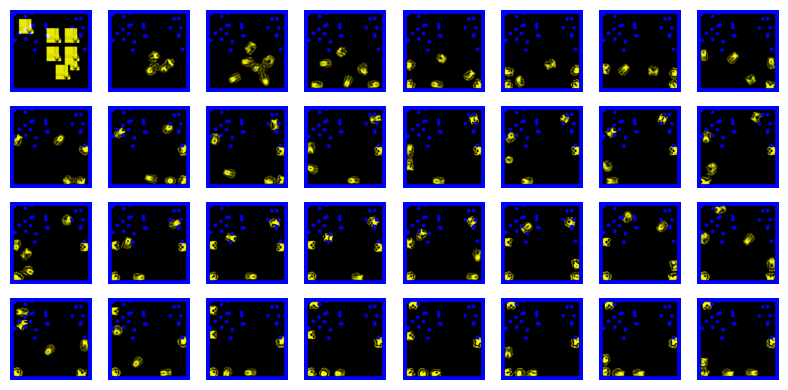

exit log_context_duration for Creating video
!!! {"Creating video": 5.685610294342041}
enter log_context_duration for Creating reversed video


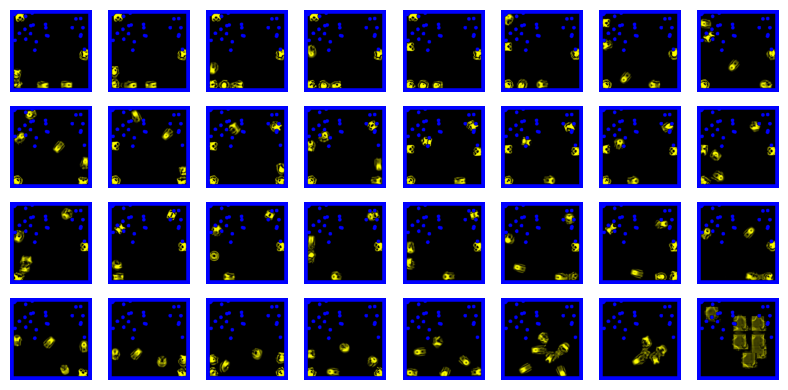

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.708902835845947}


100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


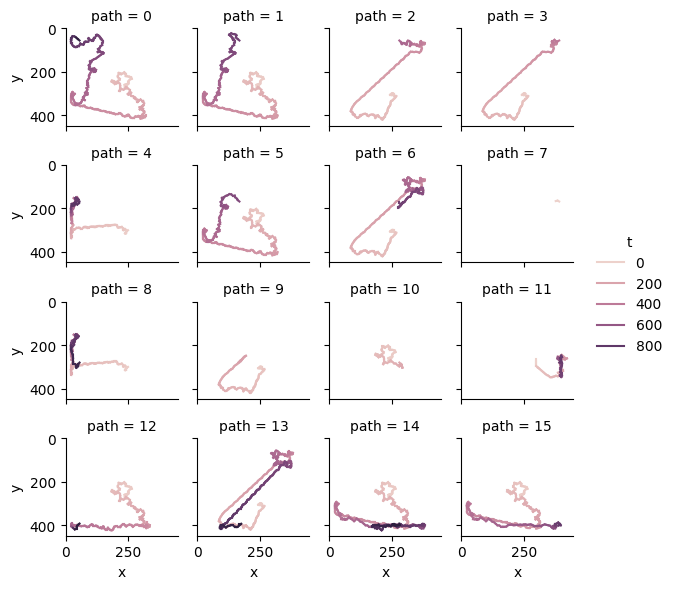

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 37.95665264129639}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15494751930236816}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 171.68064260482788}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 19.41746711730957}


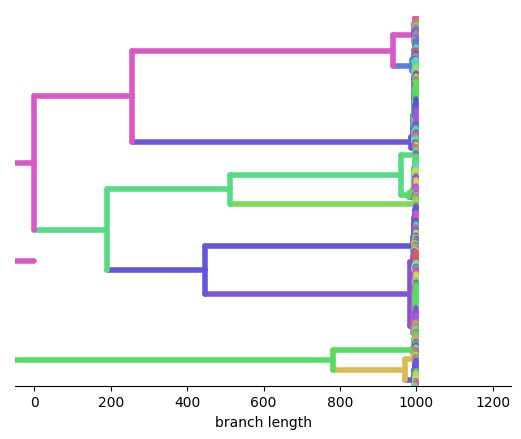

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.15464210510254}
enter log_context_duration for Creating video


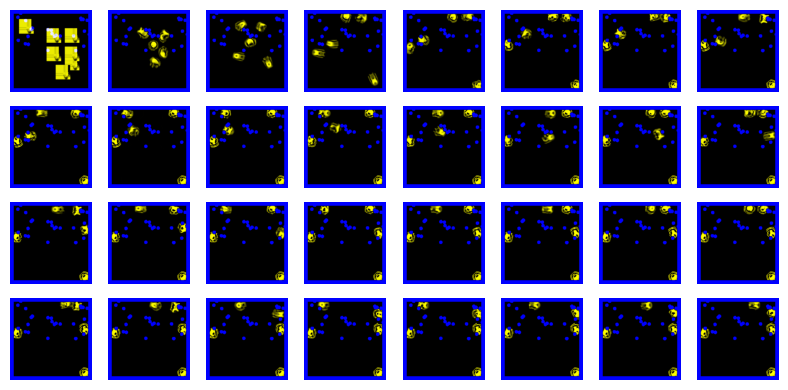

exit log_context_duration for Creating video
!!! {"Creating video": 5.66725754737854}
enter log_context_duration for Creating reversed video


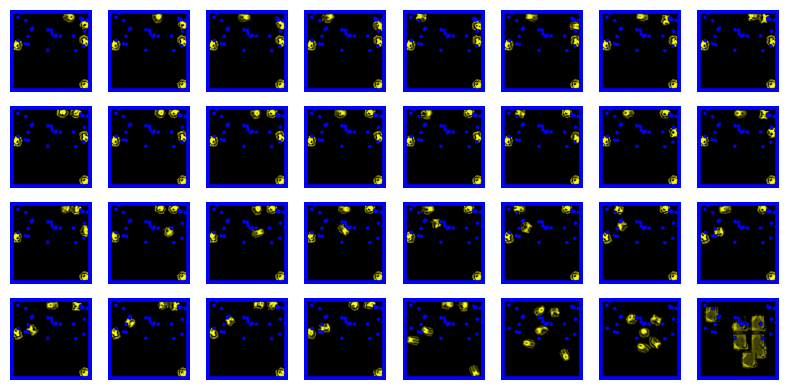

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.681507349014282}


100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


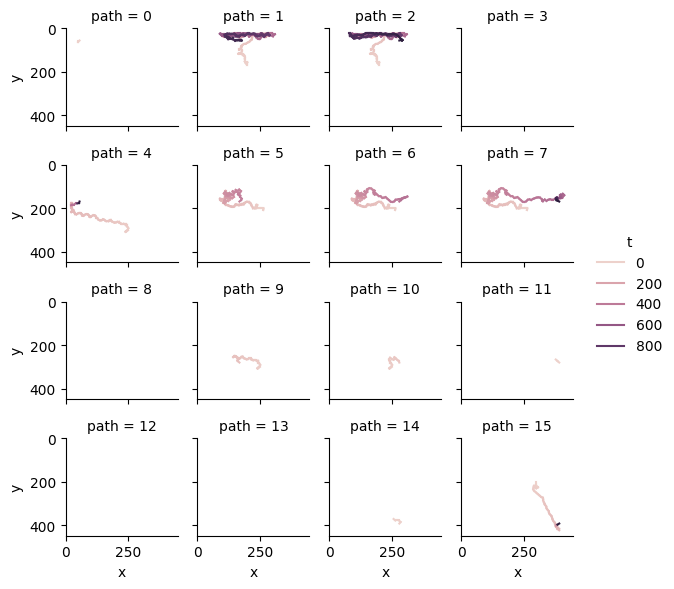

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 36.9479558467865}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.14818692207336426}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.995083332061768}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 16.05861496925354}


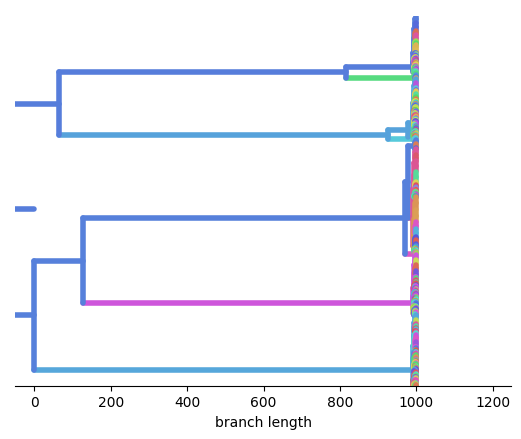

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.304271697998047}
enter log_context_duration for Creating video


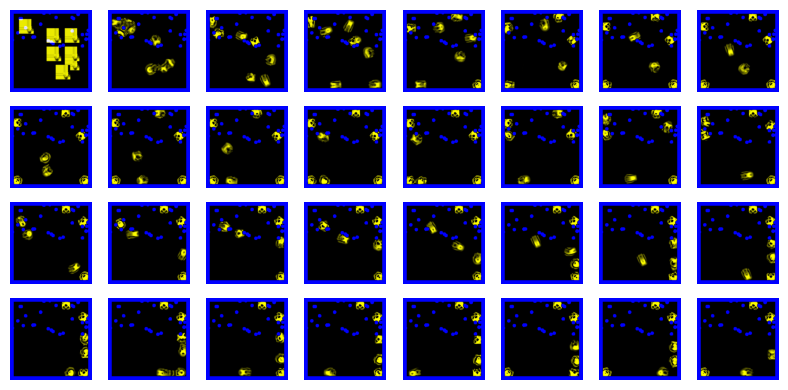

exit log_context_duration for Creating video
!!! {"Creating video": 5.702725887298584}
enter log_context_duration for Creating reversed video


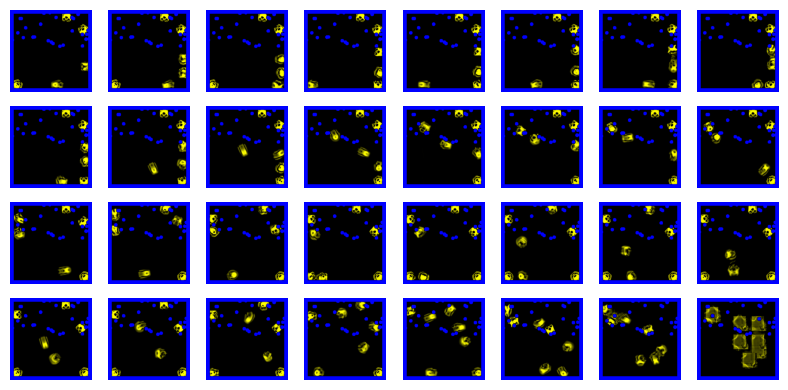

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.7511420249938965}


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


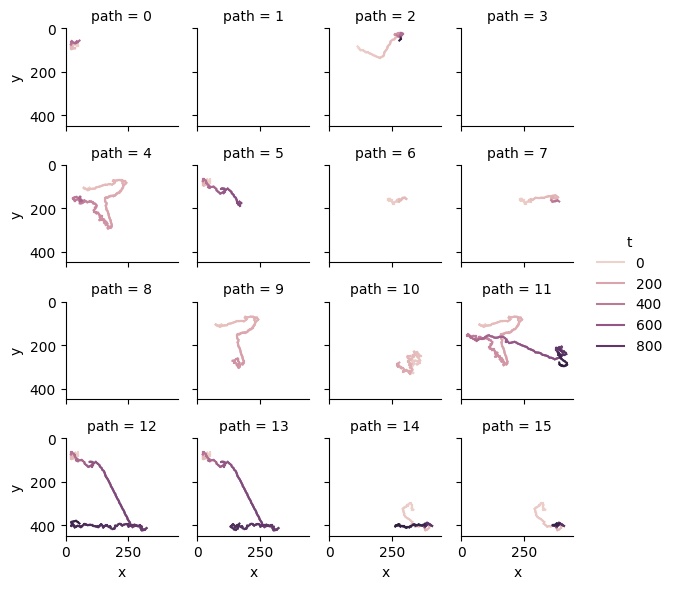

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.611584186553955}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1529083251953125}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.3352689743042}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 15.627840757369995}


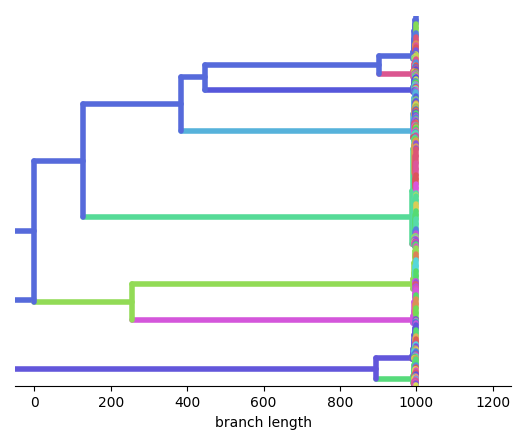

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.162435293197632}
enter log_context_duration for Creating video


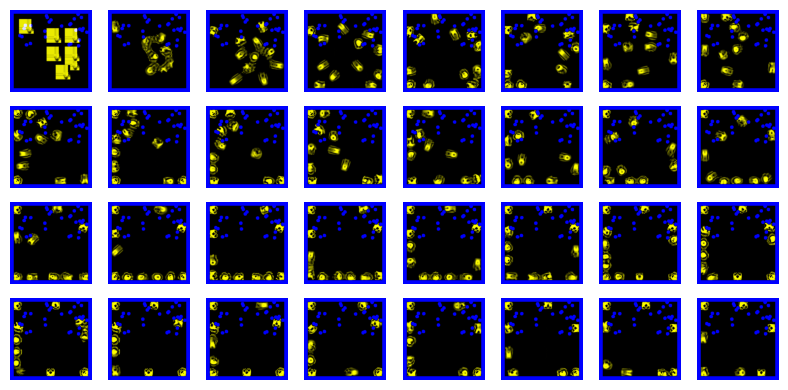

exit log_context_duration for Creating video
!!! {"Creating video": 6.165312051773071}
enter log_context_duration for Creating reversed video


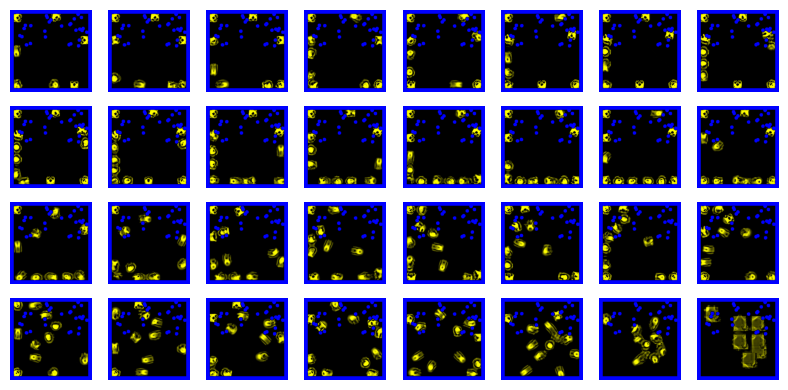

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.208019733428955}


100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


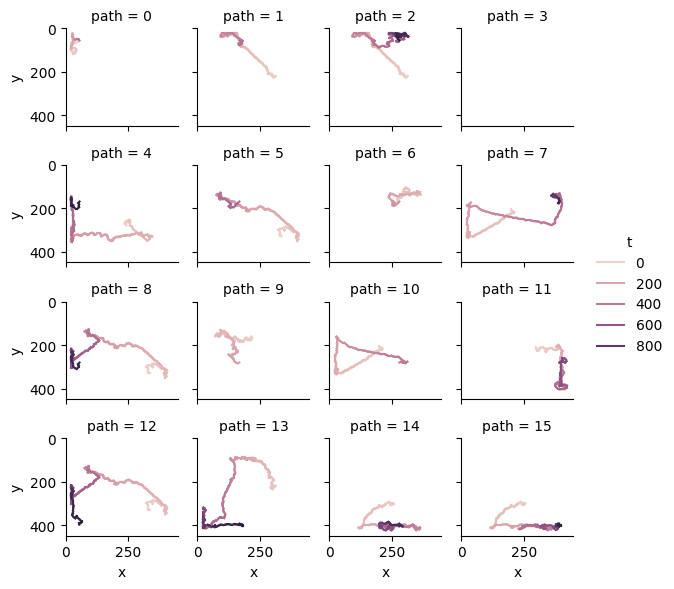

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.77915406227112}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1524949073791504}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.831296682357788}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 21.446587085723877}


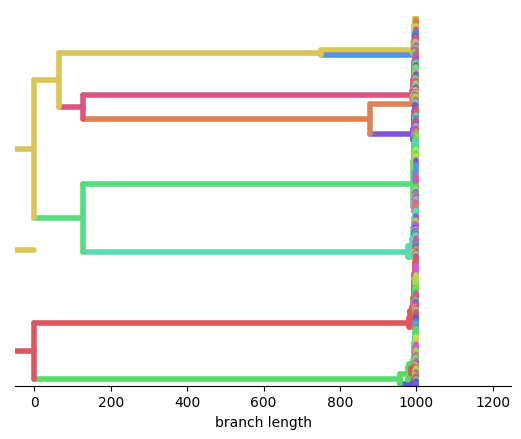

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 18.92821741104126}
enter log_context_duration for Creating video


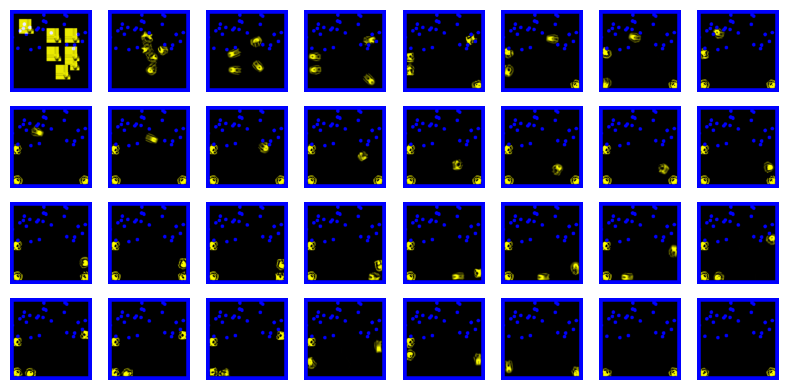

exit log_context_duration for Creating video
!!! {"Creating video": 5.0712480545043945}
enter log_context_duration for Creating reversed video


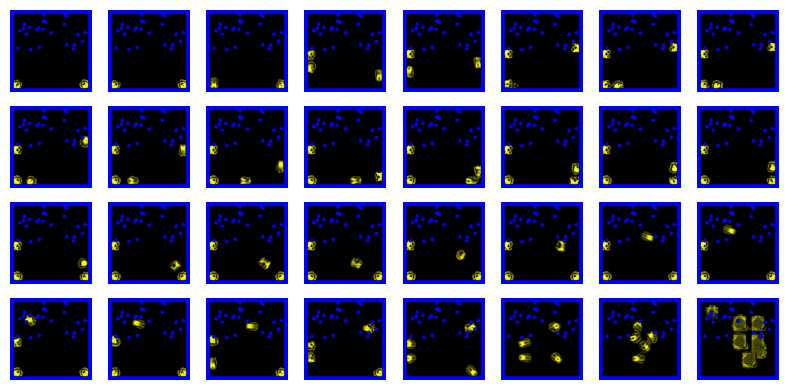

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.080273151397705}


100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


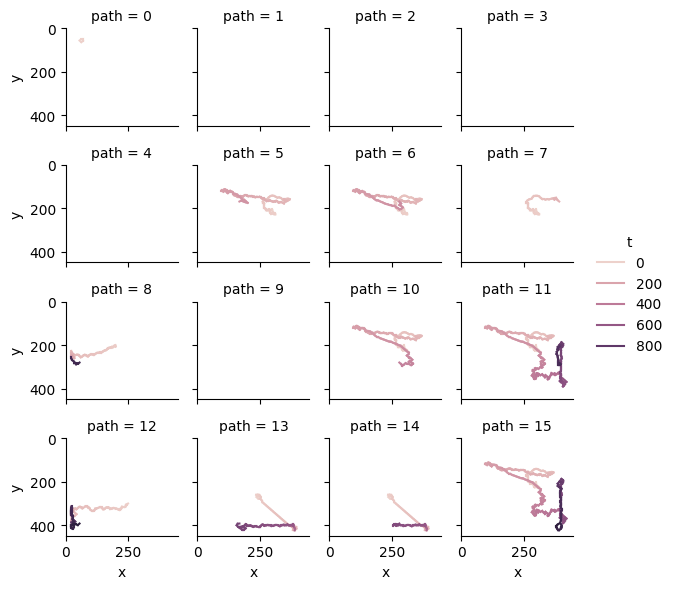

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.01086664199829}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.14982390403747559}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.101385593414307}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 5.779070615768433}


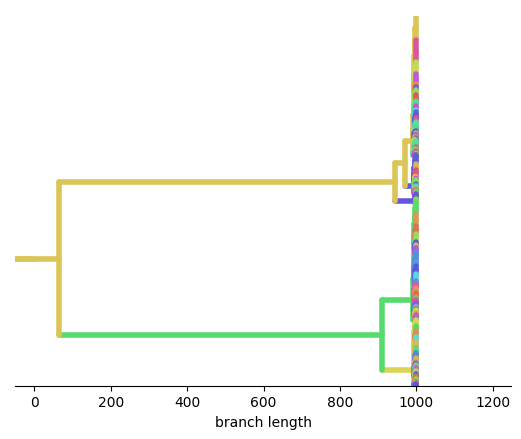

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.22573447227478}
enter log_context_duration for Creating video


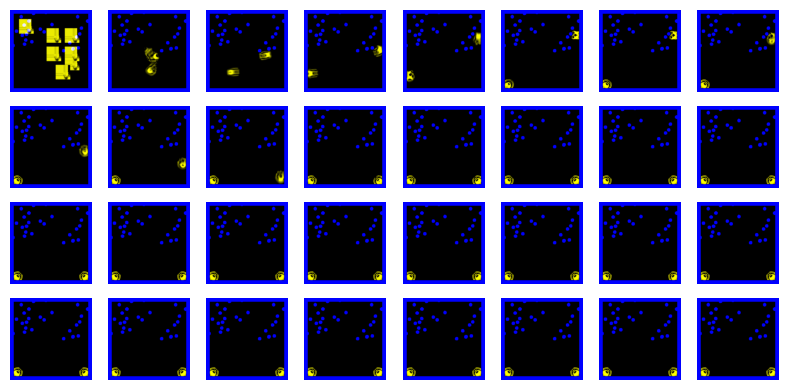

exit log_context_duration for Creating video
!!! {"Creating video": 4.49118185043335}
enter log_context_duration for Creating reversed video


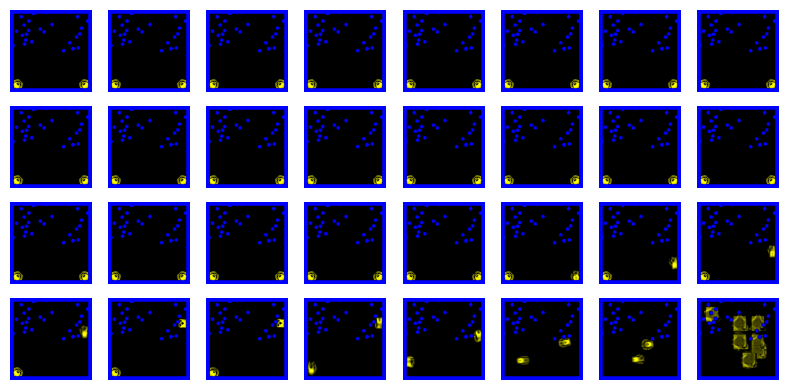

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.988509178161621}


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


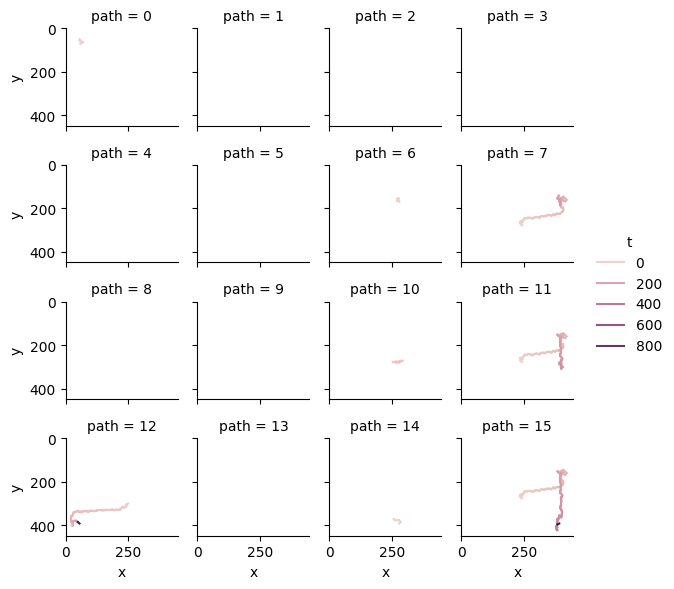

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.03087067604065}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.150726318359375}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.79961371421814}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 5.663978338241577}


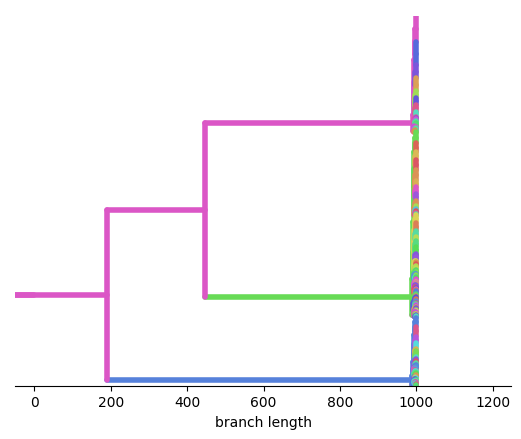

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.035244703292847}
enter log_context_duration for Creating video


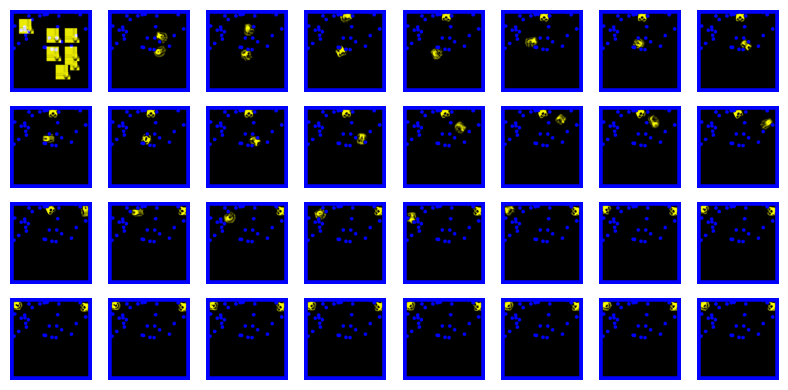

exit log_context_duration for Creating video
!!! {"Creating video": 4.5161049365997314}
enter log_context_duration for Creating reversed video


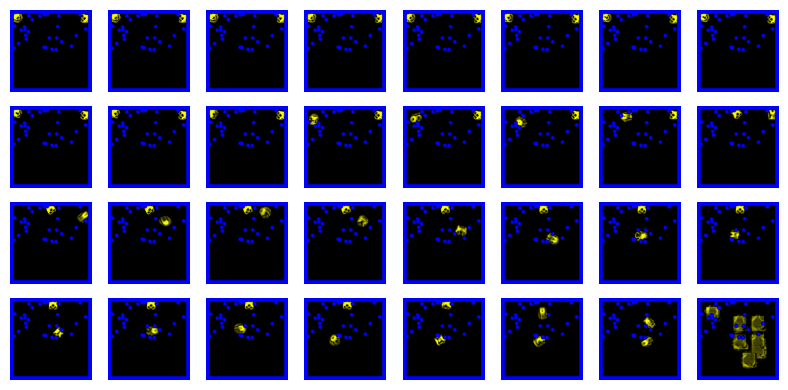

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.534119129180908}


100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


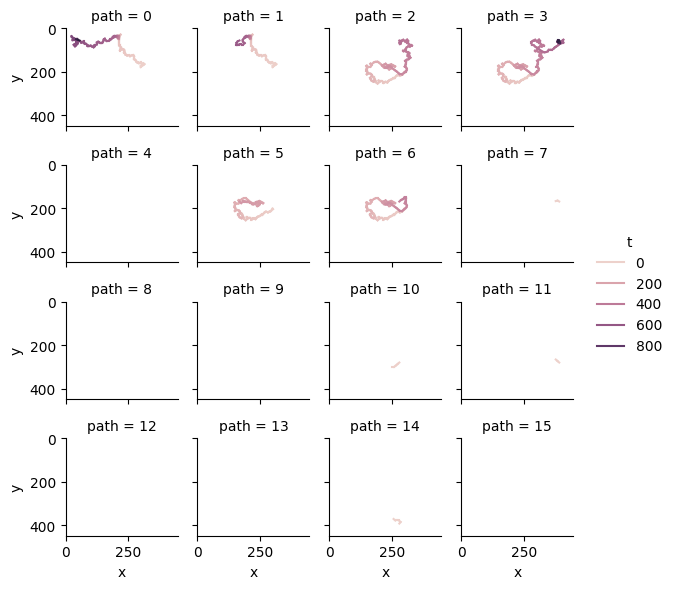

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.162065505981445}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1516728401184082}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.13293433189392}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 5.131321668624878}


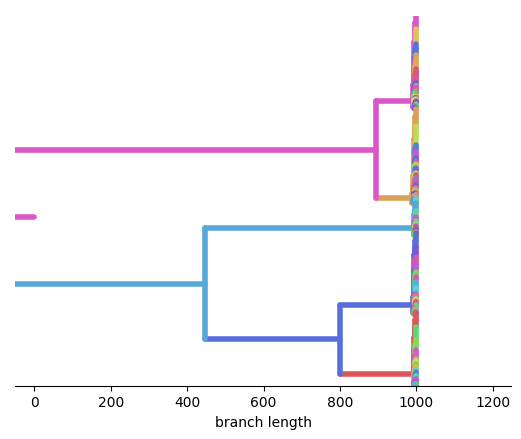

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.543341875076294}
enter log_context_duration for Creating video


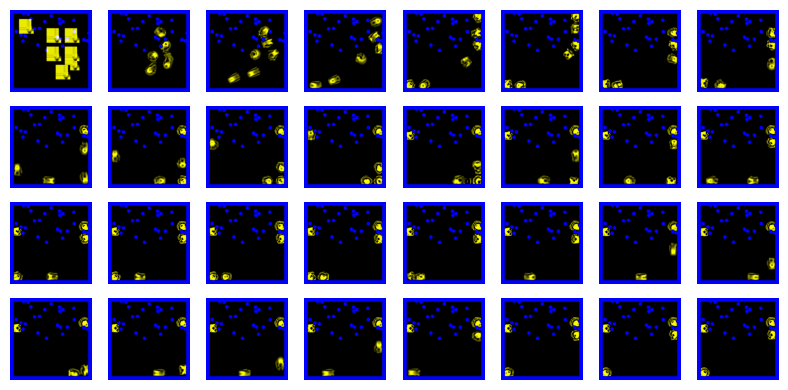

exit log_context_duration for Creating video
!!! {"Creating video": 5.542792081832886}
enter log_context_duration for Creating reversed video


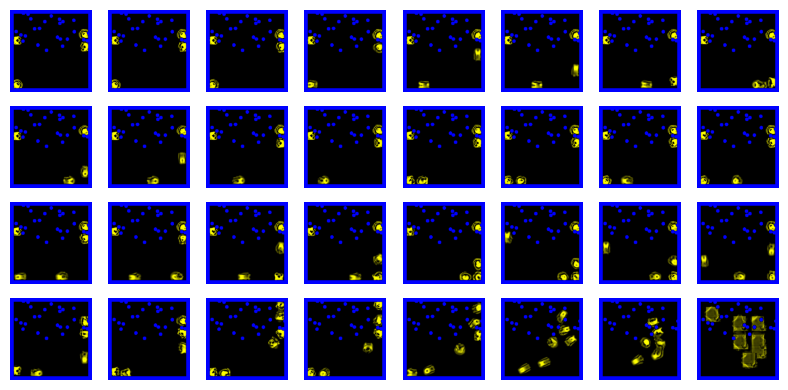

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.5587685108184814}


100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


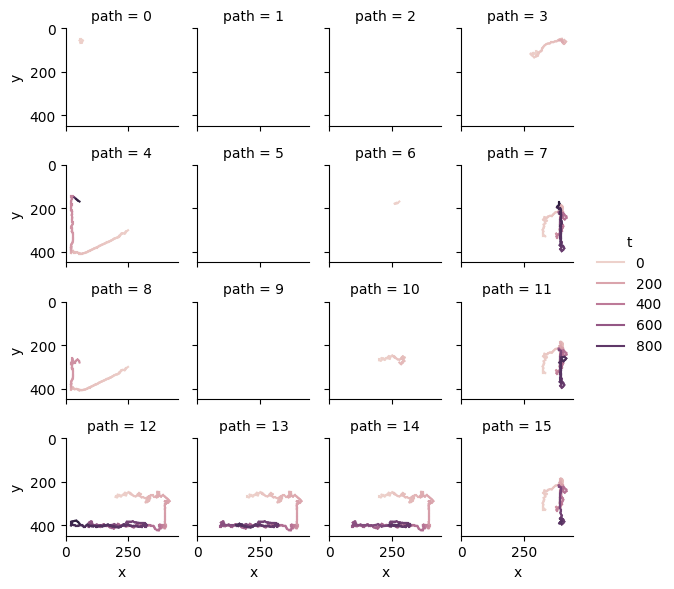

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.22643041610718}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15306377410888672}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.837831497192383}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 11.780261754989624}


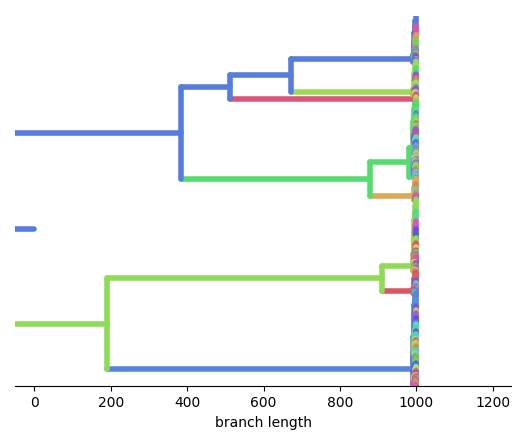

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 19.605870962142944}
enter log_context_duration for Creating video


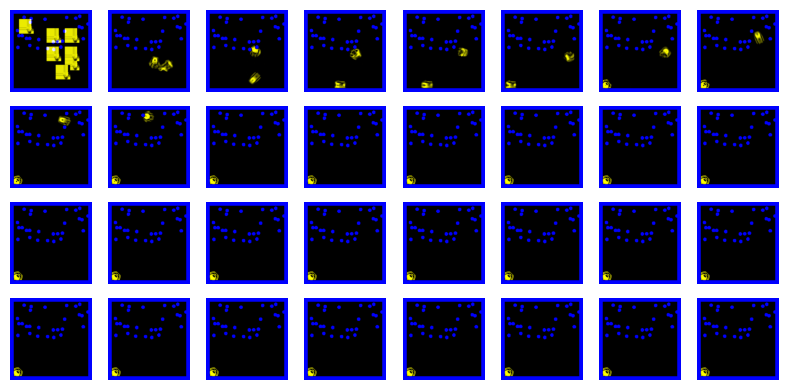

exit log_context_duration for Creating video
!!! {"Creating video": 4.304811000823975}
enter log_context_duration for Creating reversed video


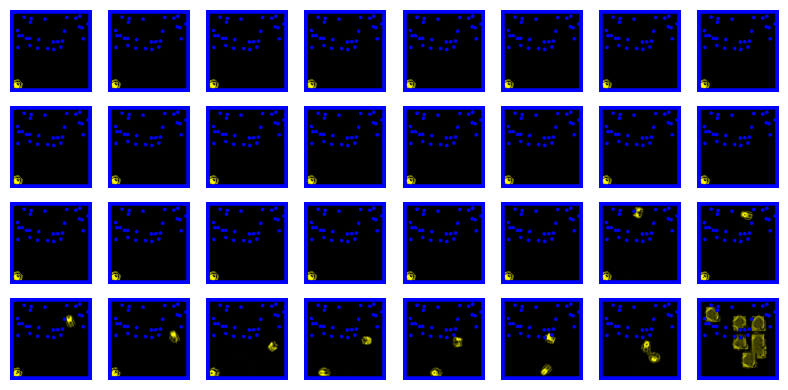

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.331845760345459}


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


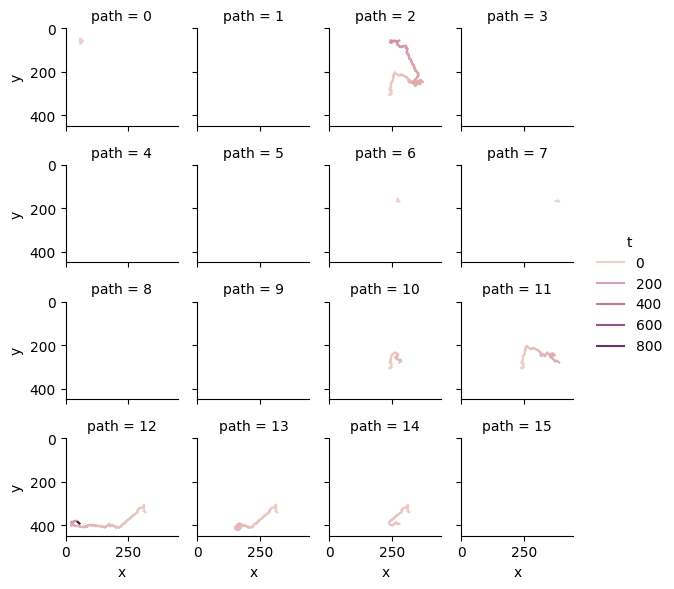

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.39908051490784}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15260744094848633}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.040642738342285}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 2.029575824737549}


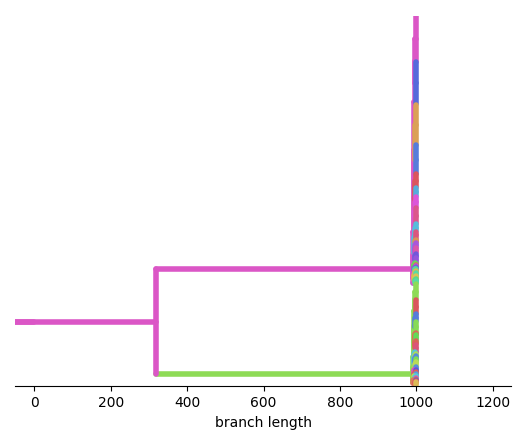

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.59590435028076}
enter log_context_duration for Creating video


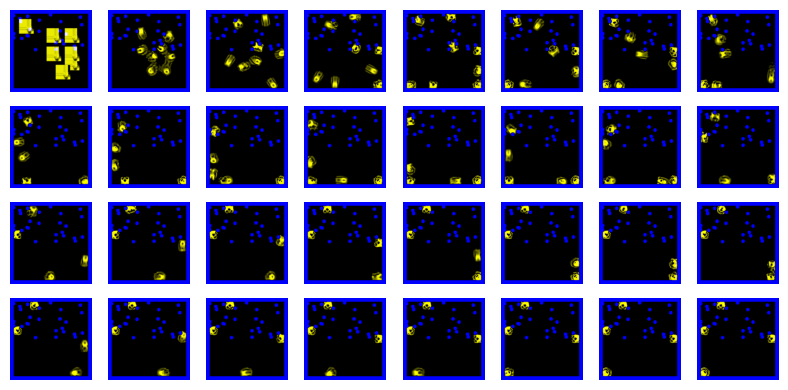

exit log_context_duration for Creating video
!!! {"Creating video": 6.659157991409302}
enter log_context_duration for Creating reversed video


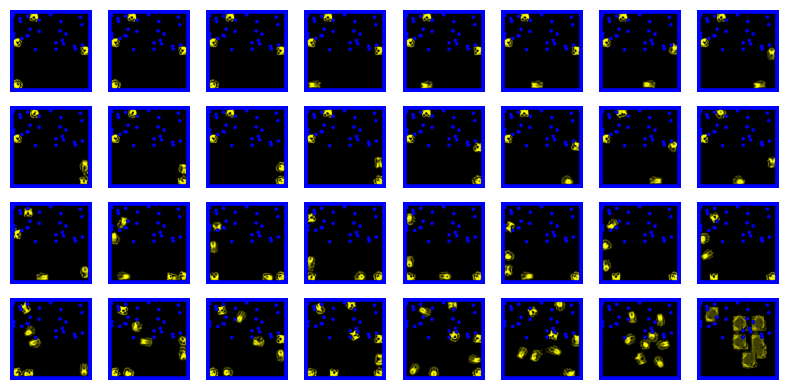

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.7450690269470215}


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


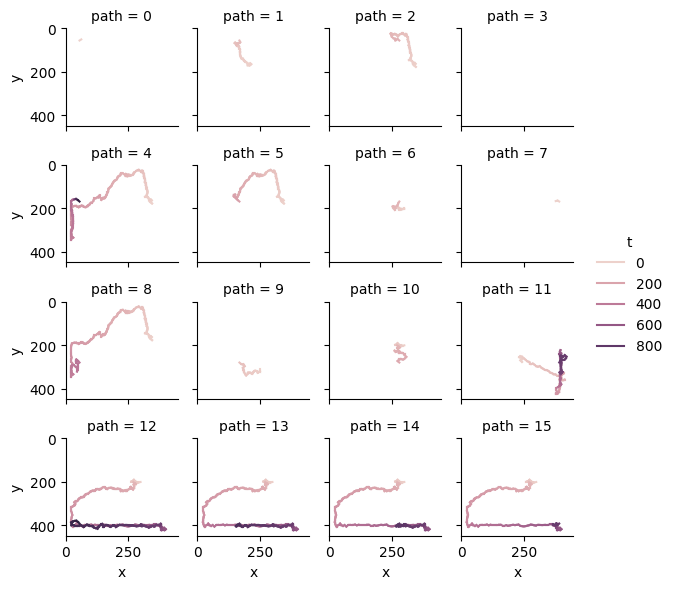

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.715447425842285}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15062665939331055}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.773988246917725}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 11.103964567184448}


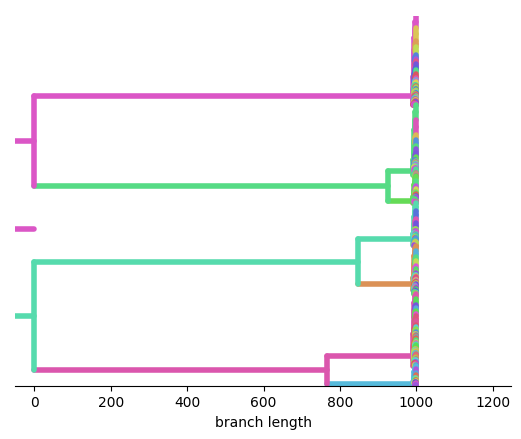

In [10]:
for i in range(10):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea1.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.94211483001709}
enter log_context_duration for Creating video


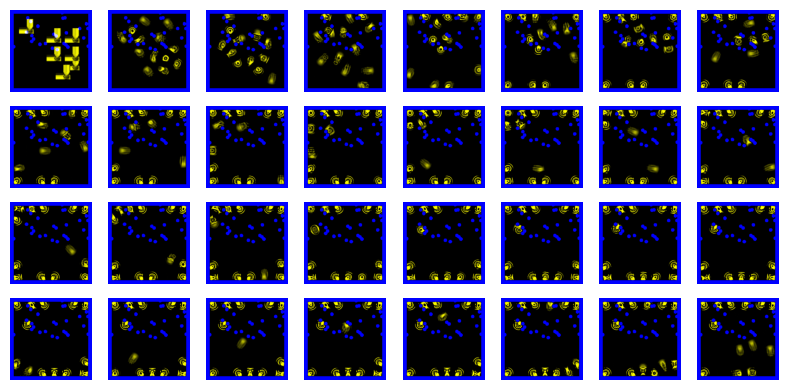

exit log_context_duration for Creating video
!!! {"Creating video": 6.153697729110718}
enter log_context_duration for Creating reversed video


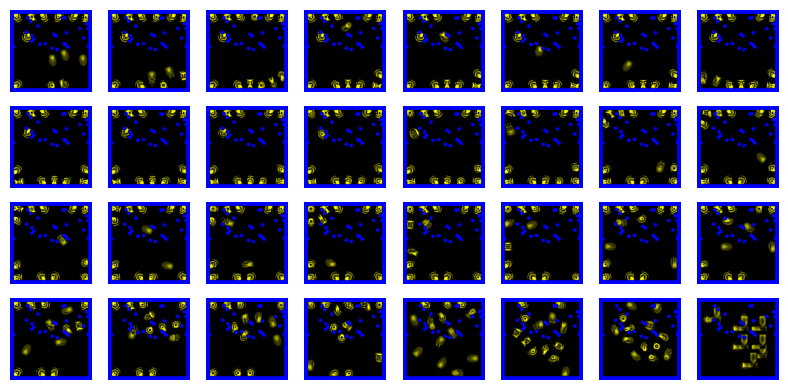

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.148313760757446}


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


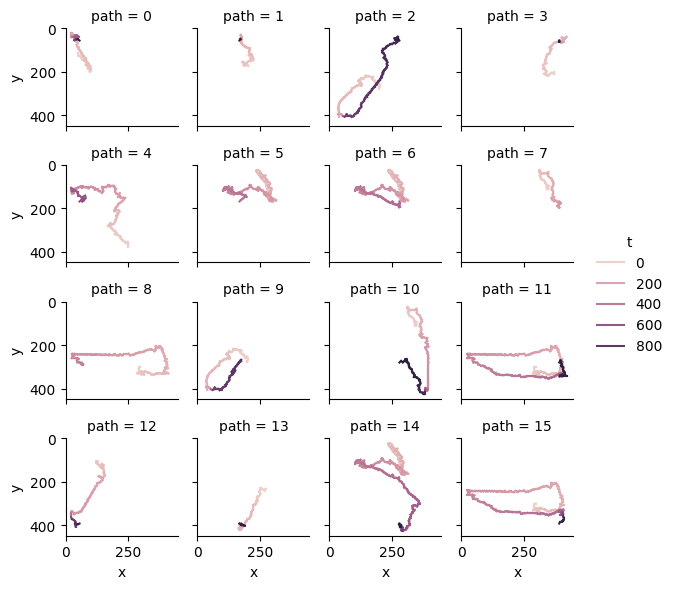

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.24028658866882}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1506650447845459}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.185752868652344}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 28.584752798080444}


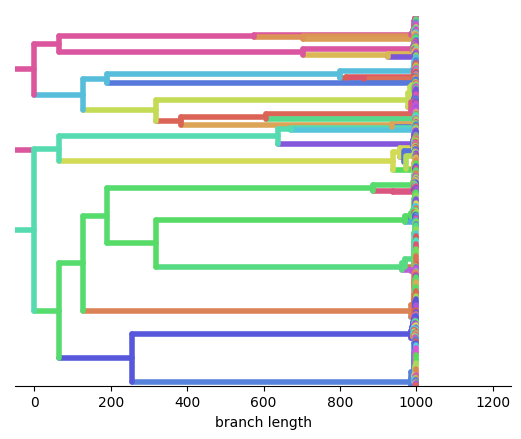

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.286516666412354}
enter log_context_duration for Creating video


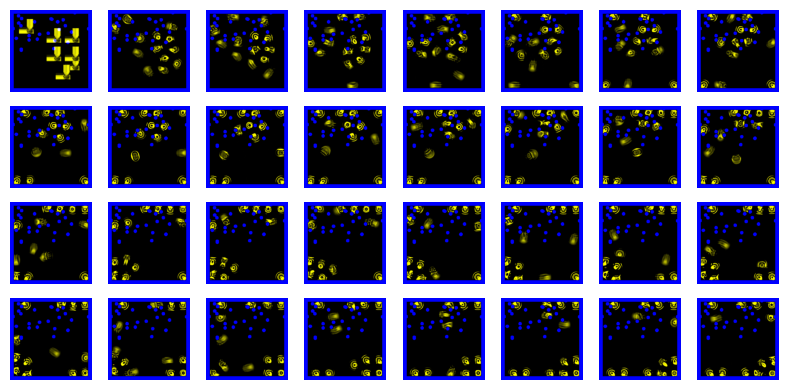

exit log_context_duration for Creating video
!!! {"Creating video": 6.159923553466797}
enter log_context_duration for Creating reversed video


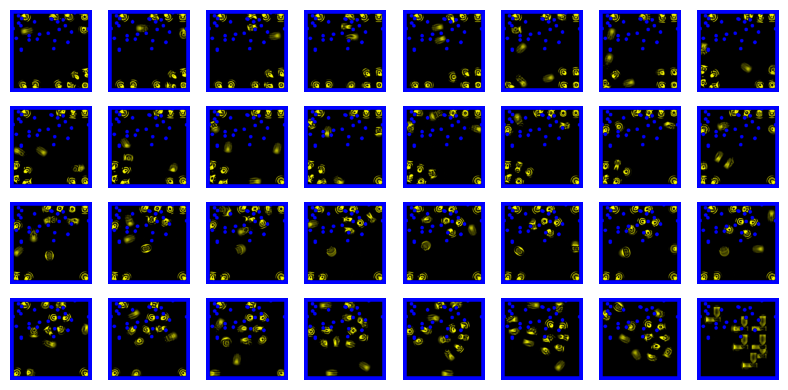

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.112446546554565}


100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


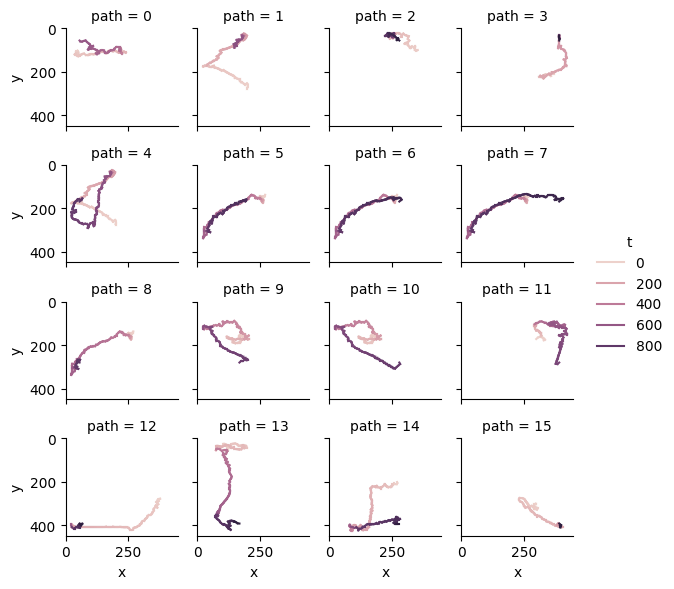

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.26268196105957}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15585994720458984}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.103621244430542}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 26.480347394943237}


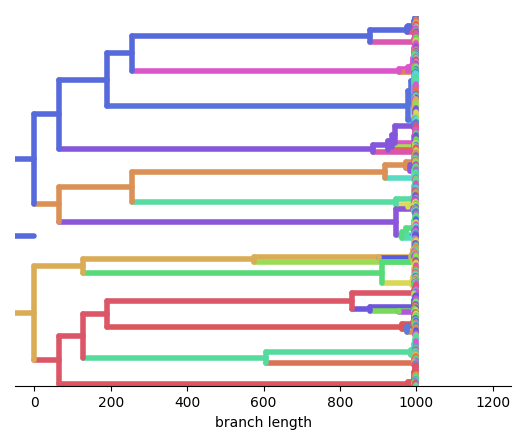

In [11]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea2.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )
